# Resolutions

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import re
import matplotlib
from collections import OrderedDict
import numpy as np
import matplotlib.pyplot as plt
import pynocular as pn
import pickle
from scipy import stats
from retro.utils.stats import estimate
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText
import pandas

In [183]:
# before SPE priors
#rootdir = '/data/justin/retro/recos/2018-03-28/tblptlog/'
# with SPE priors
rootdir = '/data/justin/retro/recos/2018-04-05.1/1460/'

p = re.compile(r'evt(\d*)-llhp.npy')

events = []

# this is just because of a mismatch
#new_names = ('llh', 'z', 'track_azimuth', 'track_zenith', 'track_energy', 'y', 'cascade_energy', 't', 'x')

prev_subdir = None

mn_failed = 0
estimator_failed = 0

for subdir, dirs, files in os.walk(rootdir):
    print subdir
    # load truth
    
    if len(files) == 0:
        continue
    
    if not subdir == prev_subdir:
        with open(os.path.join('/data/icecube/sim/ic86/retro/1460/', os.path.basename(subdir), 'mc_truth.pkl'), 'rb') as f:
            truth_file = pickle.load(f)
        with open(os.path.join('/data/icecube/sim/ic86/retro/1460/', os.path.basename(subdir), 'recos/IC86_Dunkman_L6_MultiNest8D_Track.pkl'), 'rb') as f:
            track_file = pickle.load(f)
        with open(os.path.join('/data/icecube/sim/ic86/retro/1460/', os.path.basename(subdir), 'recos/IC86_Dunkman_L6_MultiNest8D_Cascade.pkl'), 'rb') as f:
            cascade_file = pickle.load(f)
        with open(os.path.join('/data/icecube/sim/ic86/retro/1460/', os.path.basename(subdir), 'recos/SPEFit2.pkl'), 'rb') as f:
            spefit_file = pickle.load(f)
        prev_subdir == subdir
    
    for file in files:
        if p.match(file):
            event_number = int(re.sub('[^0-9]', '', file))

            llhp_data = np.load(os.path.join(subdir, file))
            if len(llhp_data['llh']) < 5000:
                print 'event %i bad (N=%i)'%(event_number, len(llhp_data['llh']))
                mn_failed += 1
                continue
            
            meta_fname = os.path.join(subdir, 'evt%i-multinest_meta.pkl'%event_number)
            with open(meta_fname, 'rb') as f:
                meta = pickle.load(f)
            #llhp_data.dtype.names = new_names
            try:
                estimator = estimate(llhp_data, percentile_nd=0.99, meta=meta)
            except IndexError:
                print 'event %i estimator failed'%(event_number)
                estimator_failed += 1
                continue
                
            event = {}
            
            # --- Retro ---
            # construct "energy"
            estimator['mean']['energy'] = estimator['mean']['cascade_energy'] + estimator['mean']['track_energy']
            estimator['weighted_mean']['energy'] = estimator['weighted_mean']['cascade_energy'] + estimator['weighted_mean']['track_energy']
            estimator['median']['energy'] = estimator['median']['cascade_energy'] + estimator['median']['track_energy']
            estimator['weighted_median']['energy'] = estimator['weighted_median']['cascade_energy'] + estimator['weighted_median']['track_energy']
            estimator['low']['energy'] = estimator['low']['cascade_energy'] + estimator['low']['track_energy']
            estimator['high']['energy'] = estimator['high']['cascade_energy'] + estimator['high']['track_energy']
            # add to dict
            for key in estimator['mean'].keys():
                event['retro_%s_mean'%key] = estimator['mean'][key]
                event['retro_%s_weighted_mean'%key] = estimator['weighted_mean'][key]
                event['retro_%s_median'%key] = estimator['median'][key]
                event['retro_%s_weighted_median'%key] = estimator['weighted_median'][key]
                event['retro_%s'%key] = estimator['weighted_median'][key]
                event['retro_%s_high'%key] = estimator['high'][key]
                event['retro_%s_low'%key] = estimator['low'][key]
                event['retro_%s_delta'%key] = estimator['high'][key] - estimator['low'][key]
                
            # --- Truth ---                
            truth = truth_file[event_number]
            truth['track_azimuth'] = truth['azimuth']
            truth['track_zenith'] = np.arccos(truth['coszen'])
            truth['track_energy'] = truth['highest_energy_daughter_energy']
            truth['neutrino_energy'] = truth['energy']
            truth['energy'] = truth['track_energy'] + truth['cascade_energy'] 
            #truth['time'] = truth['time']
            event.update(truth)

            # --- Pegleg ---
            event['pegleg_x'] = track_file[event_number]['x']
            event['pegleg_y'] = track_file[event_number]['y']
            event['pegleg_z'] = track_file[event_number]['z']
            event['pegleg_time'] = track_file[event_number]['time']
            event['pegleg_track_azimuth'] = track_file[event_number]['azimuth']
            event['pegleg_track_zenith'] = track_file[event_number]['zenith']
            event['pegleg_track_energy'] = track_file[event_number]['energy']
            event['pegleg_cascade_energy'] = cascade_file[event_number]['energy']
            event['pegleg_energy'] = event['pegleg_track_energy'] + event['pegleg_cascade_energy']

            # --- SPEFit ---
            spefit = spefit_file[event_number]
            event['spefit_x'] = spefit['x']
            event['spefit_y'] = spefit['y']
            event['spefit_z'] = spefit['z']
            event['spefit_time'] = spefit['time']
            event['spefit_track_zenith'] = spefit['zenith']
            event['spefit_track_azimuth'] = spefit['azimuth']

            
            events.append(event)

/data/justin/retro/recos/2018-04-05.1/1460/
/data/justin/retro/recos/2018-04-05.1/1460/52
/data/justin/retro/recos/2018-04-05.1/1460/41
/data/justin/retro/recos/2018-04-05.1/1460/47
/data/justin/retro/recos/2018-04-05.1/1460/25
/data/justin/retro/recos/2018-04-05.1/1460/49
/data/justin/retro/recos/2018-04-05.1/1460/29
/data/justin/retro/recos/2018-04-05.1/1460/31
/data/justin/retro/recos/2018-04-05.1/1460/61
/data/justin/retro/recos/2018-04-05.1/1460/101
/data/justin/retro/recos/2018-04-05.1/1460/21
/data/justin/retro/recos/2018-04-05.1/1460/80
/data/justin/retro/recos/2018-04-05.1/1460/55
/data/justin/retro/recos/2018-04-05.1/1460/2
/data/justin/retro/recos/2018-04-05.1/1460/82
/data/justin/retro/recos/2018-04-05.1/1460/12
/data/justin/retro/recos/2018-04-05.1/1460/66
/data/justin/retro/recos/2018-04-05.1/1460/100
/data/justin/retro/recos/2018-04-05.1/1460/27
/data/justin/retro/recos/2018-04-05.1/1460/8
/data/justin/retro/recos/2018-04-05.1/1460/3
/data/justin/retro/recos/2018-04-05.1

In [184]:
df = pandas.DataFrame(events)
df.to_pickle('data.pkl')
#df = pandas.read_pickle('data.pkl')

# drop all nan values
df = df.dropna()
events = pn.PointData(df)

In [185]:
print 'good :',len(events)
print 'failed :',mn_failed
print 'estimator failed :', estimator_failed

good : 10121
failed : 2
estimator failed : 0


In [186]:
mask = np.logical_and(np.logical_and(np.logical_and(events['retro_track_zenith_delta'] < 10, events['retro_x_delta'] < 50),events['retro_y_delta'] < 50), events['retro_z_delta'] < 30)

In [187]:
energy_corr_cscd = 1.0
energy_corr_trck = 1.0
energy_offset = 0.
events['retro_neutrino_energy'] = energy_corr_trck*events['retro_track_energy'] + energy_corr_cscd*events['retro_cascade_energy'] + energy_offset
events['retro_neutrino_energy_low'] = energy_corr_trck*events['retro_track_energy_low'] + energy_corr_cscd*events['retro_cascade_energy_low'] + energy_offset
events['retro_neutrino_energy_high'] = energy_corr_trck*events['retro_track_energy_high'] + energy_corr_cscd*events['retro_cascade_energy_high'] + energy_offset
events['pegleg_neutrino_energy'] = events['pegleg_energy']

In [188]:
e_bins = pn.Grid()
e_bins['energy'].edges = np.logspace(np.log10(np.nanmin(events['energy'])),np.log10(np.nanmax(events['energy'])),11)
hists = pn.GridData(e_bins)

x
y
z
time
track_zenith
track_azimuth
track_energy
cascade_energy
energy

--- retro ---


--- hybrid ---


--- spefit ---



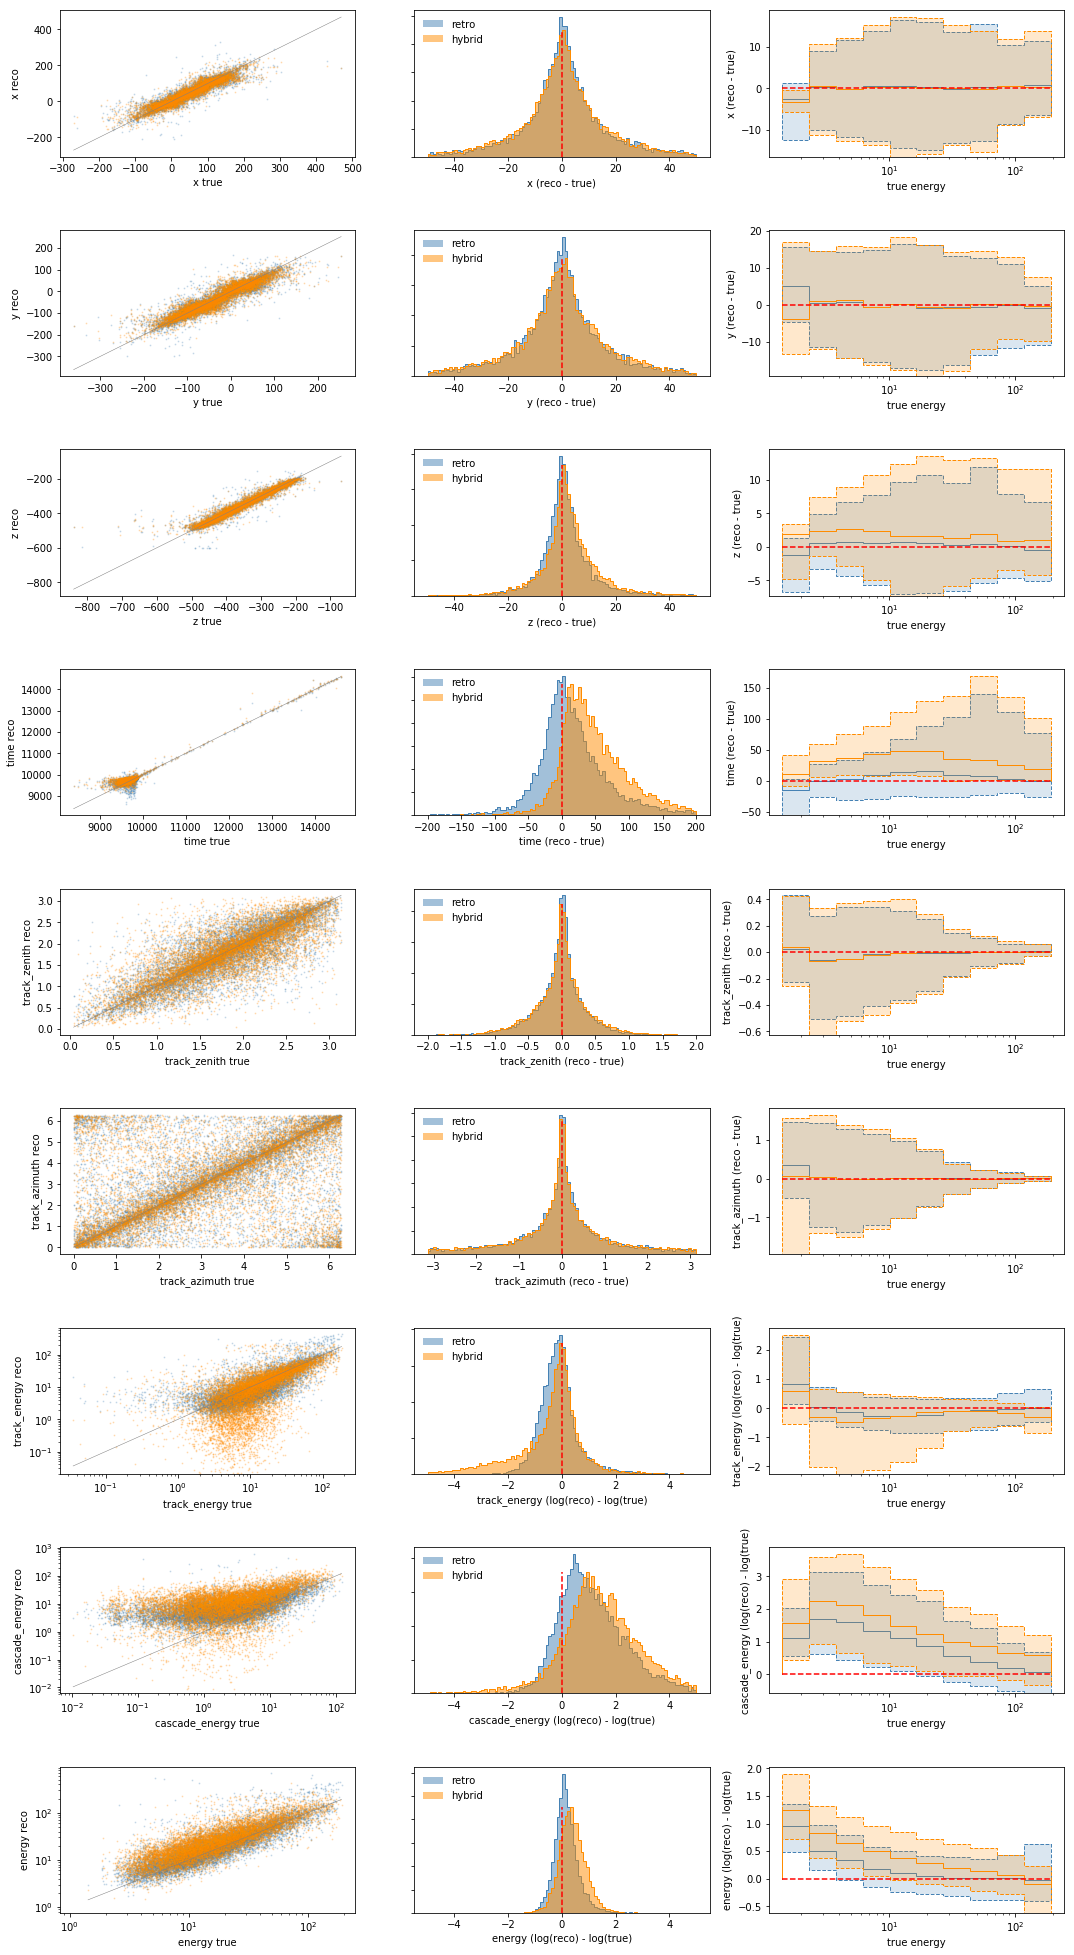

In [189]:
fig, axes = plt.subplots(figsize=(18, 35), ncols=3, nrows=9)
plt.subplots_adjust(hspace = 0.5)

res = []
pegres = []
speres = []


recos = ['retro', 'pegleg']
labels = ['retro', 'hybrid']
colors = ['steelblue', 'darkorange']

for i, dim in enumerate(['x', 'y', 'z', 'time', 'track_zenith', 'track_azimuth', 'track_energy', 'cascade_energy', 'energy']):#, 'neutrino_energy']):
    print dim
    ax1 = axes[i,0]
    ax2 = axes[i,1]
    ax3 = axes[i,2]

    estimator = '_weighted_mean'
    
    # diagonal
    d = [np.nanmin(events[dim]),np.nanmax(events[dim])]
    ax1.plot(d,d, color='gray', linewidth=0.5)


    if dim in ['x','y','z']:
        bins = np.linspace(-50, 50, 101)
    elif dim == 'time':
        bins = np.linspace(-200, 200, 101)
    elif 'azimuth' in dim:
        bins = np.linspace(-np.pi, np.pi, 101)
    elif 'zenith' in dim:
        bins = np.linspace(-2, 2, 101)
    elif 'energy' in dim:
        bins = np.linspace(-5, 5, 101)
    else:
        raise NotImplementedError()
    
    for reco, color, label in zip(recos, colors, labels):
        key = reco+'_'+dim
        if reco == 'retro':
            key += estimator

        # ------------scatter plots---------------

        events.plot_2d(fig, ax1, dim, key, color=color, s=1, alpha=0.2)
    
    
        # ------------diff histos---------------
        d_key = reco+'_d_'+dim
        
        if 'energy' in dim:
            events[d_key] = np.log(events[key]) - np.log(events[dim])
            #events[d_key][~np.isfinite(events[d_key])] = 10
        else:
            events[d_key] = events[key] - events[dim]
        #events[d_key] = events[d_key][np.isfinite(diff)]
        if 'azimuth' in dim:
            events[d_key]  = (events[d_key] + np.pi)%(2*np.pi) - np.pi
        ax2.hist(events[d_key], bins=bins, normed=True, color=color, alpha=0.5, label=label, histtype='stepfilled')
        h,_,_ = ax2.hist(events[d_key], bins=bins, normed=True, color=color, histtype='step', lw=1)

        # ------------resolution bands---------------

        hists[d_key] = events.histogram(d_key, function=np.percentile, q=50)
        hists[d_key+'_upper'] = events.histogram(d_key, function=np.percentile, q=84)
        hists[d_key+'_lower'] = events.histogram(d_key, function=np.percentile, q=16)

        hists.plot_step(fig, ax3, d_key, histtype='step', color=color, label=label)
        hists.plot_step(fig, ax3, d_key+'_lower', histtype='step', color=color, linestyle='--')
        hists.plot_step(fig, ax3, d_key+'_upper', histtype='step', color=color, linestyle='--')
        hists.plot_band(fig, ax3, d_key+'_lower', d_key+'_upper', color=color, alpha=0.2, label=label)

    
    # ---- axis formatting
    ax1.set_xlabel('true energy')            
    ax1.set_xlabel('%s true'%dim)
    ax1.set_ylabel('%s reco'%dim)
    
    ax2.legend(loc='upper left',ncol=1, frameon=False,numpoints=1,fontsize=10)
    ax2.vlines(0,0,h.max(), color='r', linestyle='--')    
    ax2.tick_params(labelleft='off')
    
    ax3.plot([hists.grid.edges[0][0],hists.grid.edges[0][-1]],[0,0],ls='--', c='red')
    ax3.set_xscale('log')
    ax3.set_xlabel('true energy')

    
    if 'energy' in dim:
        ax1.set_xscale('log')
        ax1.set_yscale('log')
        ax2.set_xlabel('%s (log(reco) - log(true)'%dim)
        ax3.set_ylabel('%s (log(reco) - log(true)'%dim)
    else:
        ax2.set_xlabel('%s (reco - true)'%dim)
        ax3.set_ylabel('%s (reco - true)'%dim)


        
        
        
        
        
    continue
    #ax1.set_ylim(x_true[x_true != 0].min(), x_true.max())
    #ax1.set_xlim(x_true[x_true != 0].min(), x_true.max())        
    #fit = np.polyfit(x_true, x_reco, 1, w = 1./(x_high - x_low))
    #x = np.linspace(x_true.min(), x_true.max(),1000)
    #y = np.polyval(fit, x)
    #ax1.plot(x,y)
    #ax1.plot(x,x,ls='--', c='r')

    # resolutions
        
    #if 'energy' in dim:
    #    diff = np.nan_to_num(np.log(x_reco) - np.log(x_true))
    #    pegleg_diff = np.nan_to_num(np.log(pegleg) - np.log(x_true))
    #else:
    diff = x_reco-x_true
    pegleg_diff = pegleg-x_true
    spefit_diff = spefit-x_true        
        
    if 'azimuth' in dim:
        diff  = (diff + np.pi)%(2*np.pi) - np.pi
        pegleg_diff  = (pegleg_diff + np.pi)%(2*np.pi) - np.pi
        spefit_diff  = (spefit_diff + np.pi)%(2*np.pi) - np.pi

    if dim in ['x','y','z']:
        bins = np.linspace(-50, 50, 101)
    elif dim == 'time':
        bins = np.linspace(-200, 200, 101)
    elif 'azimuth' in dim:
        bins = np.linspace(-np.pi, np.pi, 101)
    elif 'zenith' in dim:
        bins = np.linspace(-2, 2, 101)
    elif 'energy' in dim:
        bins = np.linspace(-5, 5, 101)
    else:
        raise NotImplementedError()
        
        
        
    ax2.hist(pegleg_diff, bins=bins, normed=True, color='orange', alpha=0.5, label='hybrid')
    ax2.hist(pegleg_diff, bins=bins, normed=True, color='orange', histtype='step', lw=1)
    if not 'energy' in dim:
        ax2.hist(spefit_diff, bins=bins, normed=True, histtype='step',color='green', lw=1,label='SPEFit')
    
    h,_,_ = ax2.hist(diff,bins=bins, normed=True, alpha=0.5,color='royalblue',label='retro')
    ax2.hist(diff,bins=bins, normed=True, alpha=0.5, histtype='step', lw=1, color='blue')
    ax2.set_xlabel('%s (reco - true)'%dim)

    
    #mu, std = stats.norm.fit(diff)
    #x = np.linspace(diff.min(), diff.max(),1000)
    #p = stats.norm.pdf(x, mu, std)
    #ax2.plot(x,p)

    text = 'mean: %.3f\nstd:  %.3f\nmedian: %.3f\n+err:%.3f\n-err:%.3f'%(np.mean(diff), np.std(diff), np.percentile(diff, 50), np.percentile(diff, 50)-np.percentile(diff, 16), np.percentile(diff, 84)-np.percentile(diff, 50))

    res.append('%s width = %.3f, bias = %.3f'%(dim, (np.percentile(diff, 84)-np.percentile(diff, 16))/2, np.median(diff)))
    pegres.append('%s width = %.3f, bias = %.3f'%(dim, (np.percentile(pegleg_diff, 84)-np.percentile(pegleg_diff, 16))/2, np.median(pegleg_diff)))
    speres.append('%s width = %.3f, bias = %.3f'%(dim, (np.percentile(spefit_diff, 84)-np.percentile(spefit_diff, 16))/2, np.median(spefit_diff)))
    
    atext = AnchoredText(text,
                      prop=dict(size=12), frameon=False,
                      loc=1,
                      )
    ax2.add_artist(atext)
    ax2.legend(loc='upper left',ncol=1, frameon=False,numpoints=1,fontsize=10)
    ax2.vlines(0,0,h.max(), color='r', linestyle='--')
    ax2.tick_params(labelleft='off')
    
    # chi2
    continue
    chi2 = np.square(diff) / np.square((x_high - x_low)/2)
    h,_,_ = ax3.hist(chi2, bins=np.logspace(-2,2,101), normed=True)
    ax3.set_xlabel(r'$\chi^2$')
    fit = stats.chi2.fit(chi2, floc=0, fscale=1)
    #x = np.linspace(chi2.min(), chi2.max(), 1000)
    x = np.logspace(-2,2,1000)
    y = stats.chi2.pdf(x, *fit)
    ax3.plot(x,y)
    y = stats.chi2.pdf(x, df=1,loc=0,scale=1)
    ax3.plot(x,y, c='r', ls='--')
    #ax3.set_yscale('log')
    ax3.set_xscale('log')

    ax3.set_ylim(0,h.max())
    atext = AnchoredText('d.o.f. = %.2f'%fit[0],
                      prop=dict(size=12), frameon=False,
                      loc=1,
                      )
    ax3.add_artist(atext)
    ax3.tick_params(labelleft='off')
    
print '\n--- retro ---'   
print '\n'.join(res)
print '\n--- hybrid ---'
print '\n'.join(pegres)
print '\n--- spefit ---'
print '\n'.join(speres)


plt.savefig('res.png')

x
y
z


/home/peller/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log10
  if __name__ == '__main__':


time
track_zenith
track_azimuth


/home/peller/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in log10
  if __name__ == '__main__':


track_energy
cascade_energy
energy


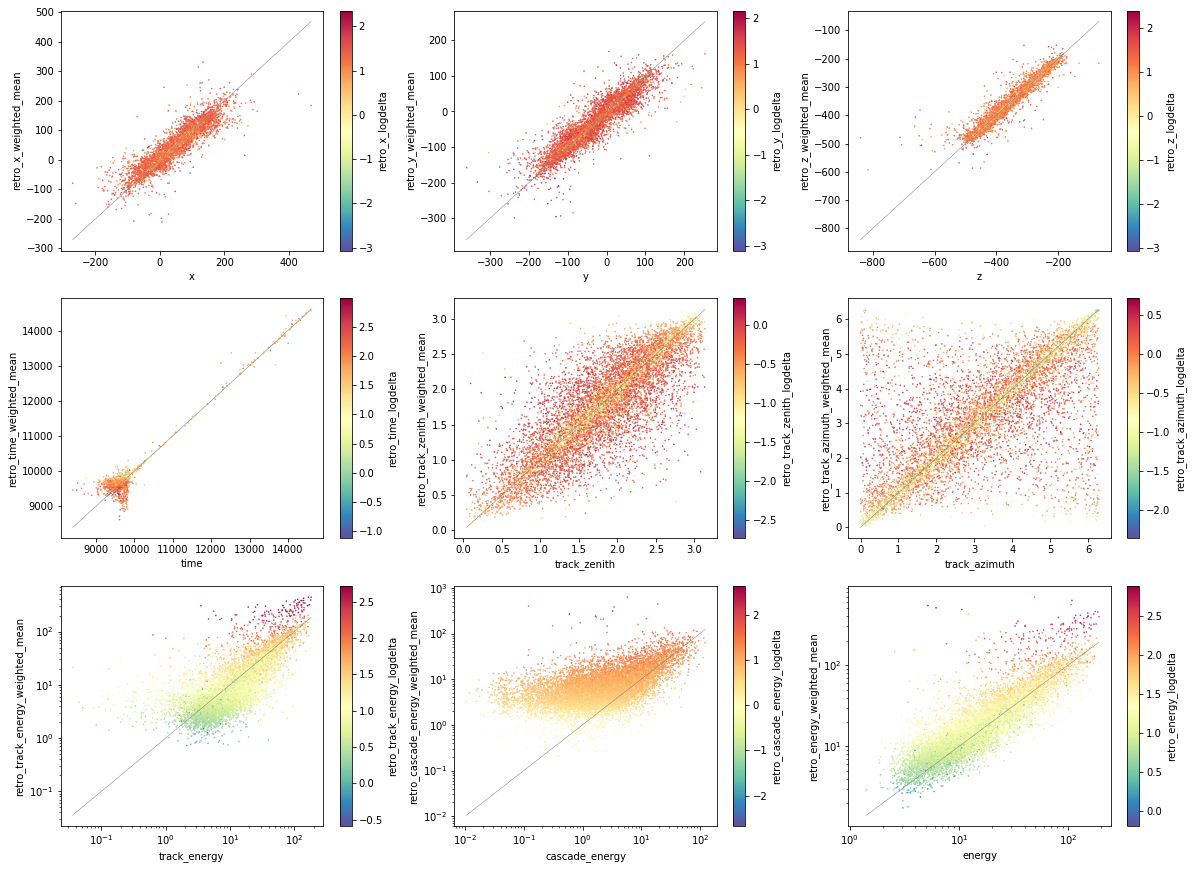

In [243]:
fig, axes = plt.subplots(figsize=(20, 15), ncols=3, nrows=3)


for i, dim in enumerate(['x', 'y', 'z', 'time', 'track_zenith', 'track_azimuth', 'track_energy', 'cascade_energy', 'energy']):#, 'neutrino_energy']):
    print dim
    ax = axes[i/3,i%3]

    err_dim = dim
    events['retro_%s_logdelta'%err_dim] = np.log10(events['retro_%s_delta'%err_dim])

    # diagonal
    d = [np.nanmin(events[dim]),np.nanmax(events[dim])]
    ax.plot(d,d, color='gray', linewidth=0.5)
    
    events.plot_2d(fig, ax, dim, 'retro_%s_weighted_mean'%dim, c='retro_%s_logdelta'%err_dim, cmap='Spectral_r', s=0.3, alpha=1, cbar=True)
    if 'energy' in dim:
        ax.set_xscale('log')
        ax.set_yscale('log')
fig.savefig('error.png')

## Error vs. true Energy

In [190]:
def angular_dist(theta1, theta2, phi1, phi2):
    '''
    calculate the angular distance between two directions in spherical coords
    '''
    return np.arccos(np.cos(theta1)*np.cos(theta2) + np.sin(theta1)*np.sin(theta2)*np.cos(phi1 - phi2))

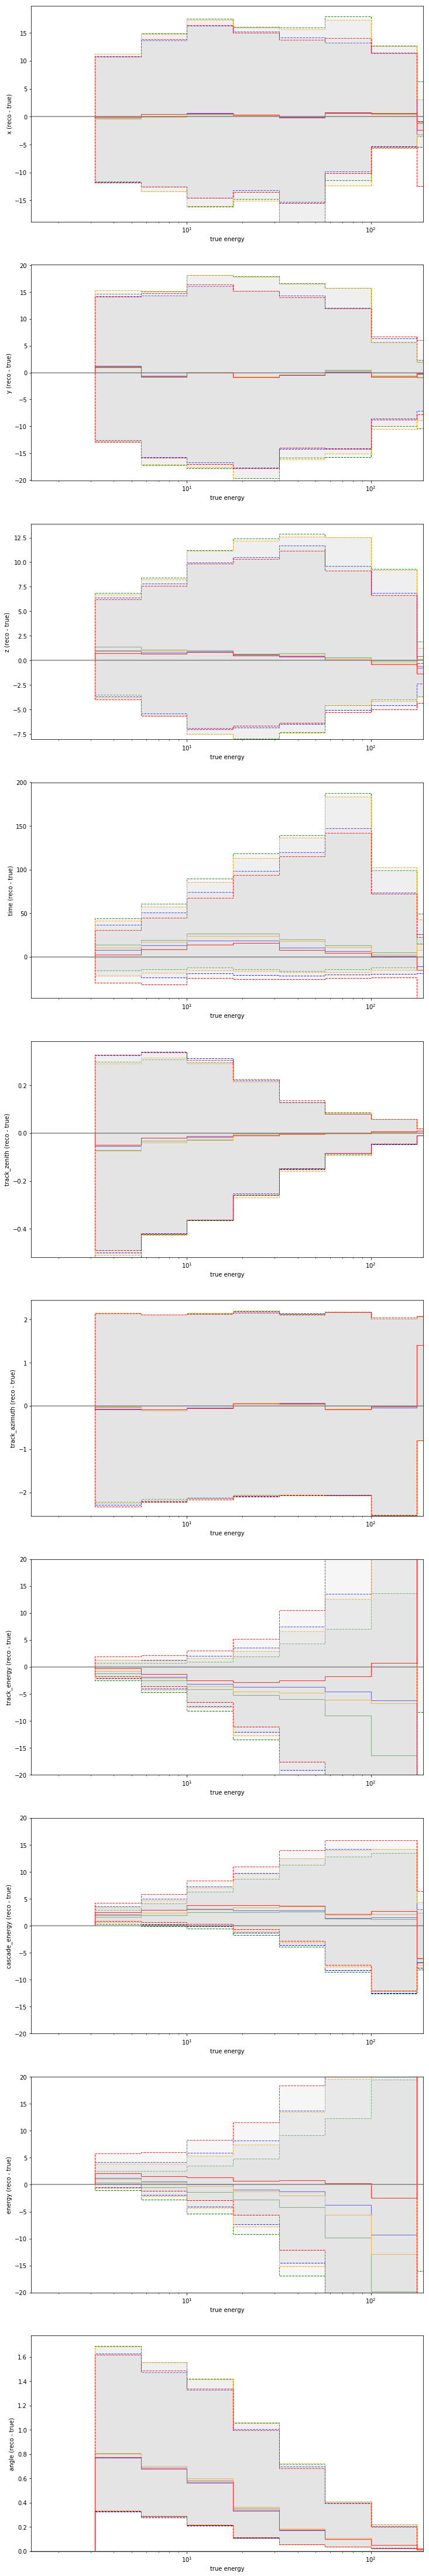

In [233]:
fig, axes = plt.subplots(figsize=(12, 80), ncols=1, nrows=10)
plt.subplots_adjust(hspace = 0.2)

res = []
pegres = []
speres = []

for i, dim in enumerate(['x', 'y', 'z', 'time', 'track_zenith', 'track_azimuth', 'track_energy', 'cascade_energy', 'energy', 'angle']):
    
    ax1 = axes[i]
    true_energy = np.nan_to_num(events['energy'])

    #for reco, color in zip(['spefit', 'retro', 'pegleg'], ['green', 'blue', 'orange']):
    for reco, color, estimator in zip(['retro', 'retro', 'retro', 'retro'], ['green', 'blue', 'orange', 'red'], ['_median', '_weighted_median', '_mean', '_weighted_mean']):
        if not ('energy' in dim and reco == 'spefit'):
            
            key = reco+'_'+dim+estimator
            d_key = reco+'_d_'+dim+estimator
            #print key
            
            if dim == 'angle':
                events[d_key] = angular_dist(events[reco+'_track_zenith'+estimator], events['track_zenith'], events[reco+'_track_azimuth'+estimator], events['track_azimuth'])
            else:
                events[d_key] = events[key] - events[dim]

            if 'azimuth' in dim:
                events[d_key]  = (events[key] + np.pi)%(2*np.pi) - np.pi

 
            hists_e[d_key] = events.histogram(d_key, function=np.percentile, q=50)
            hists_e[d_key+'_upper'] = events.histogram(d_key, function=np.percentile, q=84)
            hists_e[d_key+'_lower'] = events.histogram(d_key, function=np.percentile, q=16)

            hists_e.plot_step(fig, ax1, d_key, histtype='step', color=color, label=estimator)
            hists_e.plot_step(fig, ax1, d_key+'_lower', histtype='step', color=color, linestyle='--')
            hists_e.plot_step(fig, ax1, d_key+'_upper', histtype='step', color=color, linestyle='--')
            hists_e.plot_band(fig, ax1, d_key+'_lower', d_key+'_upper', color='lightgray', alpha=0.2, label=estimator)

    
    ax1.set_xlabel('true energy')

    if 'energy' in dim:
        ax1.set_ylim(-20, 20)

    ax1.set_ylabel('%s (reco - true)'%dim)
    ax1.set_xscale('log')
    ax1.set_xlim(true_energy[true_energy != 0].min(), true_energy.max())
    ax1.legend(loc='upper left',ncol=1, frameon=True,numpoints=1,fontsize=10)

    ax1.plot([0.01,1000],[0,0],ls='-', c='gray')
    plt.savefig('estimators.png')